### Package Installation and Environment Setup
* Install required packages
* Check PyTorch installation and CUDA availability

In [ ]:
!pip install numpy torch torchvision pillow matplotlib tqdm gdown opencv-python
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu126
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060 Ti



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Download and Extract CAPTCHA Images from Google Drive

In [ ]:
import os
import gdown
from pathlib import Path
import zipfile
import shutil

# Create directories
os.makedirs('data', exist_ok=True)
os.makedirs('data/images', exist_ok=True)

file_id = '1Qy4geTaJqoRPuaut8V-VFQYpnQS4gTds'
output = 'data/captcha_images.zip'
CAPTCHA_DIR = 'data/images'

# Check if the directory already exists
if os.path.exists(CAPTCHA_DIR) and os.listdir(CAPTCHA_DIR):
    print(f"Directory '{CAPTCHA_DIR}' already exists and is not empty.")

else:
    print(f"Directory '{CAPTCHA_DIR}' does not exist or is empty. Proceeding with download.")
    print("Downloading CAPTCHA images from Google Drive...")
    try:
        url = f'https://drive.google.com/uc?id={file_id}'
        gdown.download(url, output, quiet=False)
        print("Download complete!")
        print("Extracting ZIP file...")
        try:
            with zipfile.ZipFile(output, 'r') as zip_ref:
                zip_ref.extractall('data')
            print("Extraction complete!")

            # Check where the PNG files actually went and move them if needed
            data_dir_files = [f for f in os.listdir('data') if f.lower().endswith('.png')]

            if data_dir_files:
                print(f"Found {len(data_dir_files)} PNG files in 'data' directory")
                print("Moving files to 'data/images'...")

                # Move all PNG files from 'data' to 'data/images'
                for file in data_dir_files:
                    src_path = os.path.join('data', file)
                    dst_path = os.path.join('data/images', file)
                    shutil.move(src_path, dst_path)

                print(f"Successfully moved {len(data_dir_files)} PNG files to 'data/images'")
            else:
                # Check if images might be in a subdirectory
                png_files = []
                for root, dirs, files in os.walk("data"):
                    for file in files:
                        if file.lower().endswith('.png'):
                            full_path = os.path.join(root, file)
                            png_files.append(full_path)

                if png_files:
                    print(f"Found {len(png_files)} PNG files in subdirectories")
                    print("First few files:")
                    for file in png_files[:5]:
                        print(f"  - {file}")

                    # Extract the directory where most images are
                    dir_counts = {}
                    for file in png_files:
                        parent_dir = os.path.dirname(file)
                        dir_counts[parent_dir] = dir_counts.get(parent_dir, 0) + 1

                    # Find directory with most images
                    most_common_dir = max(dir_counts.items(), key=lambda x: x[1])[0]
                    print(f"Most images found in: {most_common_dir}")

                    # Update CAPTCHA_DIR to this location
                    CAPTCHA_DIR = most_common_dir
                else:
                    print("No PNG files found after extraction")
                    CAPTCHA_DIR = 'data/images'  # Default location

        except zipfile.BadZipFile:
            print("Error: The downloaded file is not a valid ZIP file.")
            print("Please upload a valid ZIP file containing CAPTCHA images")
    except Exception as e:
        print(f"Error downloading or extracting the file: {str(e)}")
        print("Please upload the CAPTCHA images manually")

### CAPTCHA Recognition Challenge

In this notebook, we'll build a baseline model for recognizing text in CAPTCHA images.
CAPTCHAs (Completely Automated Public Turing test to tell Computers and Humans Apart)
are distorted text images designed to be difficult for computers to read.

Your task is to improve this baseline model in one of the following ways:
1. Add data augmentation for better robustness
2. Modify the architecture to reduce inference time
3. Improve preprocessing to handle noise

The baseline model achieves approximately 40-60% accuracy with high variance.
Your goal is to demonstrate measurable improvement over this baseline.

In [ ]:
import os
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Constant for CTC blank token
BLANK_TOKEN = 0

### Configuration

This Config class contains all the parameters for our model and training process.
You might want to experiment with these values as you improve the model.

In [ ]:
class Config:
    # Model parameters
    IMG_WIDTH = 65
    IMG_HEIGHT = 25
    DROPOUT_RATE = 0.3

    # Training parameters
    BATCH_SIZE = 64
    LEARNING_RATE = 0.01
    NUM_EPOCHS = 40

    # Dataset parameters
    TARGET_FOLDER = CAPTCHA_DIR
    MAX_SAMPLES = 4000            # Maximum number of samples to use
    TRAIN_RATIO = 0.9             # Ratio of training to validation data

    # Misc
    RANDOM_SEED = 69
    MODEL_SAVE_PATH = 'captcha_model.pth'

CONFIG = Config()

### Dataset Class
The CaptchaDataset class handles loading and preprocessing CAPTCHA images.
It converts the images to tensors and prepares the labels for training.

In [ ]:
class CaptchaDataset(Dataset):
    def __init__(self, image_paths, labels, char_to_idx, max_length, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.char_to_idx = char_to_idx
        self.max_length = max_length
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('L')  # Convert to grayscale

            if self.transform:
                image = self.transform(image)

            label = self.labels[idx]
            label_indices = [self.char_to_idx[c] for c in label]
            label_length = len(label)

            # Pad label to max_length
            label_indices = label_indices + [BLANK_TOKEN] * (self.max_length - label_length)

            return {
                'image': image,
                'label': torch.tensor(label_indices, dtype=torch.long),
                'label_length': torch.tensor(label_length, dtype=torch.long)
            }
        except Exception as e:
            print(f"Error loading image {self.image_paths[idx]}: {e}")
            return {
                'image': torch.zeros((1, CONFIG.IMG_HEIGHT, CONFIG.IMG_WIDTH)),
                'label': torch.tensor([BLANK_TOKEN] * self.max_length, dtype=torch.long),
                'label_length': torch.tensor(0, dtype=torch.long)
            }

### Model Architecture

Our baseline model architecture has three main components:
1. CNN layer for feature extraction
2. Bidirectional LSTM for sequence modeling
3. Linear layer for classification


In [ ]:
class CaptchaModelWithTrainablePreprocessing(nn.Module):
    """Combined model with enhanced trainable preprocessing and recognition"""
    
    def __init__(self, num_chars, dropout_rate=CONFIG.DROPOUT_RATE, 
                initial_upscale_factor=2.0,
                initial_contrast_factor=1.2,
                initial_sharpness=0.5):
        super().__init__()
        
        # Initialize the trainable preprocessor with our enhanced version
        self.preprocessor = TrainablePreprocessor(
            initial_upscale_factor=initial_upscale_factor,
            initial_contrast_factor=initial_contrast_factor,
            initial_sharpness=initial_sharpness
        )
        
        # Initialize the recognition model
        self.captcha_model = CaptchaModel(num_chars, dropout_rate)
    
    def forward(self, x):
        # First preprocess the image
        x = self.preprocessor(x)
        # Then pass to recognition model
        return self.captcha_model(x)
    
    def get_preprocessor_params(self):
        """Get current preprocessor parameters"""
        return self.preprocessor.get_params()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

class TrainablePreprocessor(nn.Module):
    """Fixed preprocessor with trainable parameters that ensures gradient flow"""
    
    def __init__(self, 
                 initial_upscale_factor=2.0,
                 initial_contrast_factor=1.2, 
                 initial_brightness=1.0,
                 initial_sharpness=0.5):
        super().__init__()
        
        # Create trainable parameters with initial values
        self.log_upscale_factor = nn.Parameter(torch.log(torch.tensor(float(initial_upscale_factor))))
        self.contrast_factor = nn.Parameter(torch.tensor(float(initial_contrast_factor)))
        self.brightness = nn.Parameter(torch.tensor(float(initial_brightness)))
        self.sharpness = nn.Parameter(torch.tensor(float(initial_sharpness)))
        
        # Learnable sharpening kernel
        kernel_init = torch.tensor([
            [-0.1, -0.5, -0.1],
            [-0.5,  5.0, -0.5],
            [-0.1, -0.5, -0.1]
        ]).float().reshape(1, 1, 3, 3) / 3.0
        
        self.sharpen_kernel = nn.Parameter(kernel_init)
        self.sharpen_blend_weight = nn.Parameter(torch.tensor(0.5))
        
    def forward(self, x):
        # Ensure parameters directly participate in computation to receive gradients
        upscale = torch.exp(self.log_upscale_factor).clamp(1.0, 4.0)
        contrast = self.contrast_factor.clamp(0.5, 3.0)
        brightness = self.brightness.clamp(0.5, 2.0)
        sharpness = torch.sigmoid(self.sharpness)  # Ensures 0-1 range with better gradients
        
        # Ensure input is in the right format [B, C, H, W]
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
            
        # Apply upscaling - IMPORTANT: calculate sizes as tensors, not items
        # This ensures gradient flow to upscale parameter
        current_height, current_width = x.shape[2], x.shape[3]
        upscale_float = upscale.clone()  # Ensure it's detached for integer conversion
        target_height = int(current_height * upscale_float.item())
        target_width = int(current_width * upscale_float.item())
        
        # Store original for residual connection
        x_original = x
        
        # Use interpolate with align_corners for better gradients
        x = F.interpolate(x, size=(target_height, target_width), 
                         mode='bilinear', align_corners=True)
        
        # Apply brightness - multiply directly with parameter for gradient flow
        x = x * brightness
        
        # Apply contrast adjustment
        x_mean = torch.mean(x, dim=[2, 3], keepdim=True)
        x = (x - x_mean) * contrast + x_mean
        
        # Apply sharpening - ensure sharpness is directly used
        # Create a padded version for convolution
        padded_x = F.pad(x, (1, 1, 1, 1), mode='reflect')
        sharpened = F.conv2d(padded_x, self.sharpen_kernel)
        
        # Key fix: Ensure sharpness parameter is directly involved in computation
        sharp_weight = sharpness * self.sharpen_blend_weight
        x = x * (1 - sharp_weight) + sharpened * sharp_weight
        
        # Resize to target dimensions for the model
        x = F.interpolate(x, size=(CONFIG.IMG_HEIGHT, CONFIG.IMG_WIDTH), 
                         mode='bilinear', align_corners=True)
        
        # Add residual connection to improve gradient flow
        x_residual = F.interpolate(x_original, size=(CONFIG.IMG_HEIGHT, CONFIG.IMG_WIDTH),
                                 mode='bilinear', align_corners=True)
        x = x * 0.8 + x_residual * 0.2
        
        # Normalize to [-1, 1] range for model
        x = (x - 0.5) / 0.5
        
        return x
    
    def get_params(self):
        """Get current parameter values for reporting"""
        return {
            'upscale_factor': torch.exp(self.log_upscale_factor).item(),
            'contrast_factor': self.contrast_factor.item(),
            'brightness': self.brightness.item(),
            'sharpness': torch.sigmoid(self.sharpness).item(),
            'sharpen_blend': self.sharpen_blend_weight.item()
        }

In [ ]:
def plot_preprocessor_evolution(history):
    """Enhanced plot showing parameter evolution and gradients during training"""
    if 'preprocessor_params' not in history:
        print("No preprocessor parameters in history")
        return
        
    params = history['preprocessor_params']
    gradients = history.get('param_gradients', [])
    epochs = list(range(1, len(params) + 1))
    
    # Plot all parameters
    plt.figure(figsize=(15, 10))
    
    # Plot each parameter's evolution
    plt.subplot(2, 3, 1)
    plt.plot(epochs, [p['upscale_factor'] for p in params], 'b-', linewidth=2)
    plt.title('Upscale Factor')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.grid(True)
    
    plt.subplot(2, 3, 2)
    plt.plot(epochs, [p['contrast_factor'] for p in params], 'g-', linewidth=2)
    plt.title('Contrast Factor')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.grid(True)
    
    plt.subplot(2, 3, 3)
    plt.plot(epochs, [p['brightness'] for p in params], 'r-', linewidth=2)
    plt.title('Brightness')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.grid(True)
    
    plt.subplot(2, 3, 4)
    plt.plot(epochs, [p['sharpness'] for p in params], 'm-', linewidth=2)
    plt.title('Sharpness')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.grid(True)
    
    # If we have gradient information, plot it
    if gradients:
        plt.subplot(2, 3, 5)
        plt.semilogy(epochs, [g['upscale_factor'] for g in gradients], 'b-', label='Upscale')
        plt.semilogy(epochs, [g['contrast_factor'] for g in gradients], 'g-', label='Contrast')
        plt.semilogy(epochs, [g['brightness'] for g in gradients], 'r-', label='Brightness')
        plt.semilogy(epochs, [g['sharpness'] for g in gradients], 'm-', label='Sharpness')
        plt.title('Parameter Gradients (log scale)')
        plt.xlabel('Epoch')
        plt.ylabel('Gradient Magnitude')
        plt.legend()
        plt.grid(True)
        
    # Plot for performance metrics
    if 'train_loss' in history and 'val_loss' in history:
        plt.subplot(2, 3, 6)
        plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
        plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
        if 'val_accuracy' in history:
            ax1 = plt.gca()
            ax2 = ax1.twinx()
            ax2.plot(epochs, history['val_accuracy'], 'g-', label='Accuracy')
            ax2.set_ylabel('Accuracy (%)')
            ax2.spines['right'].set_color('g')
            ax2.tick_params(axis='y', colors='g')
        plt.title('Training Progress')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print final values
    print("\nFinal preprocessing parameters:")
    for key in params[0].keys():
        start_val = params[0][key]
        end_val = params[-1][key]
        change = end_val - start_val
        print(f"{key}: {start_val:.3f} → {end_val:.3f} (Change: {change:+.3f})")

In [ ]:
class RawCaptchaDataset(Dataset):
    """Dataset that provides raw images without preprocessing"""
    
    def __init__(self, image_paths, labels, char_to_idx, max_length):
        self.image_paths = image_paths
        self.labels = labels
        self.char_to_idx = char_to_idx
        self.max_length = max_length

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('L')  # Convert to grayscale
            
            # Convert to tensor (0-1 range) without preprocessing
            image_tensor = transforms.ToTensor()(image)

            label = self.labels[idx]
            label_indices = [self.char_to_idx[c] for c in label]
            label_length = len(label)

            # Pad label to max_length
            label_indices = label_indices + [BLANK_TOKEN] * (self.max_length - label_length)

            return {
                'image': image_tensor,
                'label': torch.tensor(label_indices, dtype=torch.long),
                'label_length': torch.tensor(label_length, dtype=torch.long)
            }
        except Exception as e:
            print(f"Error loading image {self.image_paths[idx]}: {e}")
            # Return empty data in case of error
            return {
                'image': torch.zeros((1, CONFIG.IMG_HEIGHT, CONFIG.IMG_WIDTH)),
                'label': torch.tensor([BLANK_TOKEN] * self.max_length, dtype=torch.long),
                'label_length': torch.tensor(0, dtype=torch.long)
            }

In [ ]:
def decode_predictions(outputs, idx_to_char):
    """Convert model outputs to text predictions"""
    predictions = []
    output_args = torch.argmax(outputs.detach().cpu(), dim=2)

    for pred in output_args:
        text = ''
        prev_char = None

        for p in pred:
            p_item = p.item()
            # Only add character if it's not blank and not a repeat
            if p_item != BLANK_TOKEN and p_item != prev_char:
                if p_item in idx_to_char:
                    text += idx_to_char[p_item]
            prev_char = p_item

        predictions.append(text)

    return predictions

def get_text_from_indices(indices, idx_to_char, length):
    """Convert indices to text"""
    return ''.join([idx_to_char[idx.item()]
                  for idx in indices[:length]
                  if idx.item() != BLANK_TOKEN and idx.item() in idx_to_char])

def evaluate_with_loss(model, val_loader, device, idx_to_char, criterion):
    """Evaluation function with error handling"""
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    
    with torch.no_grad():  # No gradients needed for evaluation
        for batch in val_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device) 
            label_lengths = batch['label_length'].to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Calculate loss
            outputs_trans = outputs.transpose(0, 1)
            input_lengths = torch.full((outputs.size(0),), outputs.size(1), dtype=torch.long, device=device)
            
            loss = criterion(outputs_trans, labels, input_lengths, label_lengths)
            val_loss += loss.item()
            
            # Predict
            predictions = outputs.argmax(2)
            batch_correct = 0
            
            # Compare predictions with labels
            for i in range(len(predictions)):
                pred_label = predictions[i].tolist()
                # Remove duplicates and blanks
                decoded_pred = []
                prev = -1
                for p in pred_label:
                    if p != BLANK_TOKEN and p != prev:
                        decoded_pred.append(p)
                    prev = p
                
                # Convert indices to characters
                pred_str = ''.join([idx_to_char.get(idx, '') for idx in decoded_pred])
                
                # Get true label
                true_label = batch['label'][i][:batch['label_length'][i]].tolist()
                true_str = ''.join([idx_to_char.get(idx, '') for idx in true_label])
                
                if pred_str == true_str:
                    correct += 1
                    batch_correct += 1
                total += 1
    
    # Calculate accuracy
    accuracy = (correct / total) * 100 if total > 0 else 0
    val_loss /= len(val_loader) if len(val_loader) > 0 else 1
    
    return accuracy, val_loss, correct, total

In [ ]:
def train_model_with_trainable_preprocessing(model, train_loader, val_loader, idx_to_char, criterion=None):
    """Training function with proper gradient checking"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = model.to(device)

    # Create parameter groups with different learning rates
    optimizer = optim.Adam([
        {'params': [model.preprocessor.log_upscale_factor], 'lr': CONFIG.LEARNING_RATE * 0.5},
        {'params': [model.preprocessor.sharpness], 'lr': CONFIG.LEARNING_RATE * 0.5},
        {'params': [model.preprocessor.contrast_factor], 'lr': CONFIG.LEARNING_RATE * 0.3},
        {'params': [model.preprocessor.brightness], 'lr': CONFIG.LEARNING_RATE * 0.3},
        {'params': [model.preprocessor.sharpen_kernel], 'lr': CONFIG.LEARNING_RATE * 0.2},
        {'params': [model.preprocessor.sharpen_blend_weight], 'lr': CONFIG.LEARNING_RATE * 0.3},
        {'params': model.captcha_model.parameters(), 'lr': CONFIG.LEARNING_RATE}
    ])

    # Use scheduler to reduce learning rate during training
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    # CTC Loss for sequence labeling
    if criterion is None:
        criterion = nn.CTCLoss(blank=BLANK_TOKEN, zero_infinity=True)

    # History tracking
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'preprocessor_params': [],  # Track parameter evolution
        'param_gradients': []  # Track parameter gradients
    }

    for epoch in range(CONFIG.NUM_EPOCHS):
        # Training phase
        model.train()
        train_loss = 0.0
        epoch_gradients = {
            'upscale_factor': 0.0,
            'contrast_factor': 0.0,
            'brightness': 0.0,
            'sharpness': 0.0
        }
        batches_processed = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG.NUM_EPOCHS}"):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            label_lengths = batch['label_length'].to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Prepare for CTC loss
            outputs_trans = outputs.transpose(0, 1)
            input_lengths = torch.full((outputs.size(0),), outputs.size(1), dtype=torch.long, device=device)

            # Calculate loss
            loss = criterion(outputs_trans, labels, input_lengths, label_lengths)

            # Backward pass and optimize
            loss.backward()
            
            # FIXED: Safely check gradients and record magnitudes
            epoch_gradients['upscale_factor'] += torch.abs(model.preprocessor.log_upscale_factor.grad).item() if model.preprocessor.log_upscale_factor.grad is not None else 0.0
            epoch_gradients['contrast_factor'] += torch.abs(model.preprocessor.contrast_factor.grad).item() if model.preprocessor.contrast_factor.grad is not None else 0.0
            epoch_gradients['brightness'] += torch.abs(model.preprocessor.brightness.grad).item() if model.preprocessor.brightness.grad is not None else 0.0
            epoch_gradients['sharpness'] += torch.abs(model.preprocessor.sharpness.grad).item() if model.preprocessor.sharpness.grad is not None else 0.0
            
            # Gradient clipping to prevent large updates
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            
            optimizer.step()
            train_loss += loss.item()
            batches_processed += 1

        # Average loss for the epoch
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)
        
        # Average gradients for the epoch
        for key in epoch_gradients:
            epoch_gradients[key] /= max(1, batches_processed)
            
        history['param_gradients'].append(epoch_gradients)
        
        # Track preprocessor parameters
        history['preprocessor_params'].append(model.preprocessor.get_params())

        # Validation phase
        accuracy, val_loss, correct, total = evaluate_with_loss(
            model, val_loader, device, idx_to_char, criterion
        )
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(accuracy)
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)

        # Log metrics
        print(f"Epoch {epoch+1}/{CONFIG.NUM_EPOCHS} - "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Validation Accuracy: {accuracy:.2f}% ({correct}/{total})")
        
        # Log preprocessor parameters
        params = model.preprocessor.get_params()
        print(f"Preprocessor params: Upscale={params['upscale_factor']:.2f}, "
              f"Contrast={params['contrast_factor']:.2f}, "
              f"Brightness={params['brightness']:.2f}, "
              f"Sharpness={params['sharpness']:.2f}")
        
        # Log parameter gradients
        print(f"Parameter gradients: Upscale={epoch_gradients['upscale_factor']:.6f}, "
              f"Contrast={epoch_gradients['contrast_factor']:.6f}, "
              f"Brightness={epoch_gradients['brightness']:.6f}, "
              f"Sharpness={epoch_gradients['sharpness']:.6f}")

    # Save final model
    torch.save(model.state_dict(), CONFIG.MODEL_SAVE_PATH)
    print(f"Model saved to {CONFIG.MODEL_SAVE_PATH}")

    return model, history

In [ ]:
def visualize_dataset_samples(data_loader, idx_to_char, num_samples=16):
    """Visualize sample images from the dataset with their labels"""
    batch = next(iter(data_loader))
    images = batch['image']
    labels = batch['label']
    label_lengths = batch['label_length']

    # Calculate grid dimensions
    grid_size = min(num_samples, len(images))
    cols = 4
    rows = (grid_size + cols - 1) // cols

    plt.figure(figsize=(12, 3 * rows))

    for i in range(grid_size):
        plt.subplot(rows, cols, i + 1)

        # Convert tensor to numpy and display image
        img = images[i].squeeze().numpy()
        plt.imshow(img, cmap='gray')

        # Get the original text label
        label_length = label_lengths[i].item()
        text = get_text_from_indices(labels[i], idx_to_char, label_length)

        plt.title(f"Label: {text}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def plot_history(history):
    """Plot training history metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training and validation loss
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot validation accuracy
    ax2.plot(history['val_accuracy'])
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
def load_and_prepare_raw_data():
    """Load data without preprocessing for use with trainable preprocessor"""
    try:
        # Get all PNG files from the CAPTCHA_DIR
        if os.path.isdir(CONFIG.TARGET_FOLDER):
            dir_img = [os.path.join(CONFIG.TARGET_FOLDER, f)
                      for f in os.listdir(CONFIG.TARGET_FOLDER)
                      if f.lower().endswith('.png')]
        else:
            dir_img = [f for f in png_files if f.lower().endswith('.png')]

        if not dir_img:
            raise FileNotFoundError(f"No images found in {CONFIG.TARGET_FOLDER}")

        # Set random seed for reproducibility
        np.random.seed(CONFIG.RANDOM_SEED)
        np.random.shuffle(dir_img)

        # Limit number of samples
        if CONFIG.MAX_SAMPLES and CONFIG.MAX_SAMPLES < len(dir_img):
            dir_img = dir_img[:CONFIG.MAX_SAMPLES]

        # Extract labels from filenames
        img_labels = [os.path.splitext(os.path.basename(img))[0] for img in dir_img]

        # Create character mappings
        char_img = sorted(list(set(char for label in img_labels for char in label)))
        char_to_idx = {char: idx+1 for idx, char in enumerate(char_img)}
        idx_to_char = {idx+1: char for idx, char in enumerate(char_img)}

        # Find maximum label length for padding
        max_length = max(len(label) for label in img_labels)

        # Split data into train and validation sets
        train_size = int(len(dir_img) * CONFIG.TRAIN_RATIO)
        train_img = dir_img[:train_size]
        train_labels = img_labels[:train_size]
        val_img = dir_img[train_size:]
        val_labels = img_labels[train_size:]

        # Create datasets with raw images (no preprocessing)
        train_dataset = RawCaptchaDataset(train_img, train_labels, char_to_idx, max_length)
        val_dataset = RawCaptchaDataset(val_img, val_labels, char_to_idx, max_length)

        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False)

        print(f"Total samples: {len(dir_img)}")
        print(f"Training samples: {len(train_img)}")
        print(f"Validation samples: {len(val_img)}")
        print(f"Character set: {''.join(char_img)}")

        return train_loader, val_loader, idx_to_char, max_length

    except Exception as e:
        print(f"Error preparing data: {e}")
        raise

In [ ]:
def main_with_trainable_preprocessing():
    try:
        # Load raw data without preprocessing
        train_loader, val_loader, idx_to_char, max_length = load_and_prepare_raw_data()

        # Create model with trainable preprocessing
        num_chars = len(idx_to_char)
        model = CaptchaModelWithTrainablePreprocessing(
            num_chars=num_chars,
            initial_upscale_factor=2.0,
            initial_contrast_factor=1.2,
            initial_sharpness=0.5
        )

        print("Starting training with trainable preprocessing...")
        
        # Train the model
        model, history = train_model_with_trainable_preprocessing(
            model, train_loader, val_loader, idx_to_char
        )

        # Plot training history
        plot_history(history)
        
        # Plot preprocessor parameter evolution
        plot_preprocessor_evolution(history)

        # Report final parameters
        params = model.get_preprocessor_params()
        print("\nOptimal preprocessing parameters found by the model:")
        for param, value in params.items():
            print(f"  {param}: {value:.4f}")

        return model, history

    except Exception as e:
        print(f"Error in training: {e}")
        import traceback
        traceback.print_exc()
        return None  # Return None instead of letting the exception propagate

Total samples: 5000
Training samples: 4500
Validation samples: 500
Character set: 2345789ABCDEFHKLMNPRTUVWXYZ
Starting training with trainable preprocessing...
Using device: cuda


Epoch 1/70: 100%|██████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 1/70 - Train Loss: 4.2572, Val Loss: 3.6424, Validation Accuracy: 0.00% (0/500)
Preprocessor params: Upscale=2.00, Contrast=1.20, Brightness=1.04, Sharpness=0.63
Parameter gradients: Upscale=0.000000, Contrast=0.006546, Brightness=0.012057, Sharpness=0.000595


Epoch 2/70: 100%|██████████| 71/71 [00:03<00:00, 22.41it/s]


Epoch 2/70 - Train Loss: 3.6516, Val Loss: 3.6044, Validation Accuracy: 0.00% (0/500)
Preprocessor params: Upscale=2.00, Contrast=1.16, Brightness=1.04, Sharpness=0.63
Parameter gradients: Upscale=0.000000, Contrast=0.001833, Brightness=0.001274, Sharpness=0.000068


Epoch 3/70: 100%|██████████| 71/71 [00:03<00:00, 22.49it/s]


Epoch 3/70 - Train Loss: 3.6238, Val Loss: 3.5983, Validation Accuracy: 0.00% (0/500)
Preprocessor params: Upscale=2.00, Contrast=1.09, Brightness=1.07, Sharpness=0.63
Parameter gradients: Upscale=0.000000, Contrast=0.003793, Brightness=0.002308, Sharpness=0.000146


Epoch 4/70: 100%|██████████| 71/71 [00:03<00:00, 22.99it/s]


Epoch 4/70 - Train Loss: 3.5832, Val Loss: 3.5877, Validation Accuracy: 0.00% (0/500)
Preprocessor params: Upscale=2.00, Contrast=1.05, Brightness=1.07, Sharpness=0.63
Parameter gradients: Upscale=0.000000, Contrast=0.003408, Brightness=0.002523, Sharpness=0.000090


Epoch 5/70: 100%|██████████| 71/71 [00:03<00:00, 23.15it/s]


Epoch 5/70 - Train Loss: 3.4991, Val Loss: 3.4453, Validation Accuracy: 0.00% (0/500)
Preprocessor params: Upscale=2.00, Contrast=1.04, Brightness=1.05, Sharpness=0.62
Parameter gradients: Upscale=0.000000, Contrast=0.006221, Brightness=0.006940, Sharpness=0.000203


Epoch 6/70: 100%|██████████| 71/71 [00:03<00:00, 21.34it/s]


Epoch 6/70 - Train Loss: 3.3083, Val Loss: 3.4494, Validation Accuracy: 0.00% (0/500)
Preprocessor params: Upscale=2.00, Contrast=1.13, Brightness=0.96, Sharpness=0.62
Parameter gradients: Upscale=0.000000, Contrast=0.010204, Brightness=0.016028, Sharpness=0.001017


Epoch 7/70: 100%|██████████| 71/71 [00:02<00:00, 23.82it/s]


Epoch 7/70 - Train Loss: 2.9859, Val Loss: 2.7788, Validation Accuracy: 0.00% (0/500)
Preprocessor params: Upscale=2.00, Contrast=1.17, Brightness=0.91, Sharpness=0.64
Parameter gradients: Upscale=0.000000, Contrast=0.015360, Brightness=0.037207, Sharpness=0.004509


Epoch 8/70: 100%|██████████| 71/71 [00:03<00:00, 22.77it/s]


Epoch 8/70 - Train Loss: 2.5458, Val Loss: 2.3069, Validation Accuracy: 0.20% (1/500)
Preprocessor params: Upscale=2.00, Contrast=1.12, Brightness=0.92, Sharpness=0.64
Parameter gradients: Upscale=0.000000, Contrast=0.029886, Brightness=0.098785, Sharpness=0.009772


Epoch 9/70: 100%|██████████| 71/71 [00:03<00:00, 22.94it/s]


Epoch 9/70 - Train Loss: 1.9758, Val Loss: 1.6880, Validation Accuracy: 5.20% (26/500)
Preprocessor params: Upscale=2.00, Contrast=1.10, Brightness=0.94, Sharpness=0.63
Parameter gradients: Upscale=0.000000, Contrast=0.029712, Brightness=0.077932, Sharpness=0.005996


Epoch 10/70: 100%|██████████| 71/71 [00:03<00:00, 21.21it/s]


Epoch 10/70 - Train Loss: 1.5270, Val Loss: 1.5538, Validation Accuracy: 9.80% (49/500)
Preprocessor params: Upscale=2.00, Contrast=1.04, Brightness=0.96, Sharpness=0.62
Parameter gradients: Upscale=0.000000, Contrast=0.044667, Brightness=0.098260, Sharpness=0.003695


Epoch 11/70: 100%|██████████| 71/71 [00:03<00:00, 19.62it/s]


Epoch 11/70 - Train Loss: 1.1934, Val Loss: 0.9396, Validation Accuracy: 24.20% (121/500)
Preprocessor params: Upscale=2.00, Contrast=1.01, Brightness=0.97, Sharpness=0.63
Parameter gradients: Upscale=0.000000, Contrast=0.052469, Brightness=0.098997, Sharpness=0.003661


Epoch 12/70: 100%|██████████| 71/71 [00:03<00:00, 20.87it/s]


Epoch 12/70 - Train Loss: 0.9892, Val Loss: 1.3958, Validation Accuracy: 11.20% (56/500)
Preprocessor params: Upscale=2.00, Contrast=1.00, Brightness=0.98, Sharpness=0.62
Parameter gradients: Upscale=0.000000, Contrast=0.038492, Brightness=0.064980, Sharpness=0.003943


Epoch 13/70: 100%|██████████| 71/71 [00:03<00:00, 22.15it/s]


Epoch 13/70 - Train Loss: 0.8459, Val Loss: 0.6821, Validation Accuracy: 41.00% (205/500)
Preprocessor params: Upscale=2.00, Contrast=0.98, Brightness=0.99, Sharpness=0.63
Parameter gradients: Upscale=0.000000, Contrast=0.049006, Brightness=0.070941, Sharpness=0.002961


Epoch 14/70: 100%|██████████| 71/71 [00:03<00:00, 20.56it/s]


Epoch 14/70 - Train Loss: 0.7232, Val Loss: 0.6539, Validation Accuracy: 39.40% (197/500)
Preprocessor params: Upscale=2.00, Contrast=0.96, Brightness=1.00, Sharpness=0.62
Parameter gradients: Upscale=0.000000, Contrast=0.043030, Brightness=0.067472, Sharpness=0.003360


Epoch 15/70: 100%|██████████| 71/71 [00:02<00:00, 23.96it/s]


Epoch 15/70 - Train Loss: 0.6218, Val Loss: 0.9382, Validation Accuracy: 29.00% (145/500)
Preprocessor params: Upscale=2.00, Contrast=0.94, Brightness=1.01, Sharpness=0.63
Parameter gradients: Upscale=0.000000, Contrast=0.048696, Brightness=0.066922, Sharpness=0.003592


Epoch 16/70: 100%|██████████| 71/71 [00:03<00:00, 20.63it/s]


Epoch 16/70 - Train Loss: 0.5543, Val Loss: 0.8150, Validation Accuracy: 32.40% (162/500)
Preprocessor params: Upscale=2.00, Contrast=0.94, Brightness=1.02, Sharpness=0.64
Parameter gradients: Upscale=0.000000, Contrast=0.045133, Brightness=0.061635, Sharpness=0.003834


Epoch 17/70: 100%|██████████| 71/71 [00:03<00:00, 23.06it/s]


Epoch 17/70 - Train Loss: 0.5051, Val Loss: 0.3773, Validation Accuracy: 62.00% (310/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.03, Sharpness=0.64
Parameter gradients: Upscale=0.000000, Contrast=0.043757, Brightness=0.056713, Sharpness=0.003925


Epoch 18/70: 100%|██████████| 71/71 [00:02<00:00, 25.87it/s]


Epoch 18/70 - Train Loss: 0.4692, Val Loss: 0.5539, Validation Accuracy: 45.60% (228/500)
Preprocessor params: Upscale=2.00, Contrast=0.94, Brightness=1.04, Sharpness=0.65
Parameter gradients: Upscale=0.000000, Contrast=0.059132, Brightness=0.067813, Sharpness=0.005264


Epoch 19/70: 100%|██████████| 71/71 [00:03<00:00, 20.68it/s]


Epoch 19/70 - Train Loss: 0.4151, Val Loss: 0.4911, Validation Accuracy: 54.00% (270/500)
Preprocessor params: Upscale=2.00, Contrast=0.93, Brightness=1.04, Sharpness=0.64
Parameter gradients: Upscale=0.000000, Contrast=0.039198, Brightness=0.048465, Sharpness=0.003553


Epoch 20/70: 100%|██████████| 71/71 [00:03<00:00, 21.24it/s]


Epoch 20/70 - Train Loss: 0.3760, Val Loss: 0.7424, Validation Accuracy: 37.60% (188/500)
Preprocessor params: Upscale=2.00, Contrast=0.94, Brightness=1.04, Sharpness=0.64
Parameter gradients: Upscale=0.000000, Contrast=0.036883, Brightness=0.042628, Sharpness=0.003528


Epoch 21/70: 100%|██████████| 71/71 [00:03<00:00, 20.68it/s]


Epoch 21/70 - Train Loss: 0.3602, Val Loss: 0.3224, Validation Accuracy: 67.00% (335/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.05, Sharpness=0.65
Parameter gradients: Upscale=0.000000, Contrast=0.046593, Brightness=0.052548, Sharpness=0.004729


Epoch 22/70: 100%|██████████| 71/71 [00:03<00:00, 21.50it/s]


Epoch 22/70 - Train Loss: 0.3528, Val Loss: 0.3153, Validation Accuracy: 66.00% (330/500)
Preprocessor params: Upscale=2.00, Contrast=0.94, Brightness=1.06, Sharpness=0.66
Parameter gradients: Upscale=0.000000, Contrast=0.055403, Brightness=0.056876, Sharpness=0.004770


Epoch 23/70: 100%|██████████| 71/71 [00:03<00:00, 21.52it/s]


Epoch 23/70 - Train Loss: 0.3302, Val Loss: 0.4063, Validation Accuracy: 60.60% (303/500)
Preprocessor params: Upscale=2.00, Contrast=0.96, Brightness=1.06, Sharpness=0.65
Parameter gradients: Upscale=0.000000, Contrast=0.054963, Brightness=0.053175, Sharpness=0.004682


Epoch 24/70: 100%|██████████| 71/71 [00:03<00:00, 22.35it/s]


Epoch 24/70 - Train Loss: 0.2971, Val Loss: 0.1945, Validation Accuracy: 79.80% (399/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.06, Sharpness=0.65
Parameter gradients: Upscale=0.000000, Contrast=0.040253, Brightness=0.039831, Sharpness=0.003932


Epoch 25/70: 100%|██████████| 71/71 [00:03<00:00, 22.49it/s]


Epoch 25/70 - Train Loss: 0.2992, Val Loss: 0.6994, Validation Accuracy: 41.20% (206/500)
Preprocessor params: Upscale=2.00, Contrast=0.94, Brightness=1.06, Sharpness=0.65
Parameter gradients: Upscale=0.000000, Contrast=0.051286, Brightness=0.046723, Sharpness=0.004903


Epoch 26/70: 100%|██████████| 71/71 [00:03<00:00, 23.56it/s]


Epoch 26/70 - Train Loss: 0.2794, Val Loss: 0.2284, Validation Accuracy: 78.80% (394/500)
Preprocessor params: Upscale=2.00, Contrast=0.94, Brightness=1.07, Sharpness=0.66
Parameter gradients: Upscale=0.000000, Contrast=0.051299, Brightness=0.048022, Sharpness=0.004135


Epoch 27/70: 100%|██████████| 71/71 [00:03<00:00, 22.05it/s]


Epoch 27/70 - Train Loss: 0.2535, Val Loss: 0.2976, Validation Accuracy: 72.40% (362/500)
Preprocessor params: Upscale=2.00, Contrast=0.94, Brightness=1.07, Sharpness=0.66
Parameter gradients: Upscale=0.000000, Contrast=0.039823, Brightness=0.037856, Sharpness=0.004371


Epoch 28/70: 100%|██████████| 71/71 [00:03<00:00, 20.39it/s]


Epoch 28/70 - Train Loss: 0.2434, Val Loss: 0.1939, Validation Accuracy: 80.00% (400/500)
Preprocessor params: Upscale=2.00, Contrast=0.94, Brightness=1.07, Sharpness=0.66
Parameter gradients: Upscale=0.000000, Contrast=0.046354, Brightness=0.039892, Sharpness=0.004073


Epoch 29/70: 100%|██████████| 71/71 [00:02<00:00, 23.83it/s]


Epoch 29/70 - Train Loss: 0.2489, Val Loss: 0.1797, Validation Accuracy: 81.00% (405/500)
Preprocessor params: Upscale=2.00, Contrast=0.94, Brightness=1.08, Sharpness=0.66
Parameter gradients: Upscale=0.000000, Contrast=0.045876, Brightness=0.043077, Sharpness=0.004320


Epoch 30/70: 100%|██████████| 71/71 [00:03<00:00, 22.54it/s]


Epoch 30/70 - Train Loss: 0.2471, Val Loss: 0.1684, Validation Accuracy: 82.00% (410/500)
Preprocessor params: Upscale=2.00, Contrast=0.93, Brightness=1.07, Sharpness=0.66
Parameter gradients: Upscale=0.000000, Contrast=0.045127, Brightness=0.042203, Sharpness=0.004776


Epoch 31/70: 100%|██████████| 71/71 [00:03<00:00, 20.80it/s]


Epoch 31/70 - Train Loss: 0.2267, Val Loss: 0.2399, Validation Accuracy: 74.60% (373/500)
Preprocessor params: Upscale=2.00, Contrast=0.93, Brightness=1.08, Sharpness=0.66
Parameter gradients: Upscale=0.000000, Contrast=0.058398, Brightness=0.050412, Sharpness=0.005260


Epoch 32/70: 100%|██████████| 71/71 [00:03<00:00, 22.94it/s]


Epoch 32/70 - Train Loss: 0.2321, Val Loss: 0.2044, Validation Accuracy: 76.80% (384/500)
Preprocessor params: Upscale=2.00, Contrast=0.92, Brightness=1.09, Sharpness=0.66
Parameter gradients: Upscale=0.000000, Contrast=0.058829, Brightness=0.056445, Sharpness=0.005834


Epoch 33/70: 100%|██████████| 71/71 [00:03<00:00, 23.49it/s]


Epoch 33/70 - Train Loss: 0.2340, Val Loss: 0.2165, Validation Accuracy: 75.40% (377/500)
Preprocessor params: Upscale=2.00, Contrast=0.93, Brightness=1.09, Sharpness=0.67
Parameter gradients: Upscale=0.000000, Contrast=0.039587, Brightness=0.036643, Sharpness=0.004012


Epoch 34/70: 100%|██████████| 71/71 [00:03<00:00, 20.99it/s]


Epoch 34/70 - Train Loss: 0.2361, Val Loss: 0.3214, Validation Accuracy: 64.20% (321/500)
Preprocessor params: Upscale=2.00, Contrast=0.92, Brightness=1.09, Sharpness=0.67
Parameter gradients: Upscale=0.000000, Contrast=0.060135, Brightness=0.049797, Sharpness=0.005619


Epoch 35/70: 100%|██████████| 71/71 [00:03<00:00, 21.75it/s]


Epoch 35/70 - Train Loss: 0.1607, Val Loss: 0.1458, Validation Accuracy: 83.40% (417/500)
Preprocessor params: Upscale=2.00, Contrast=0.92, Brightness=1.09, Sharpness=0.67
Parameter gradients: Upscale=0.000000, Contrast=0.032150, Brightness=0.027254, Sharpness=0.003765


Epoch 36/70: 100%|██████████| 71/71 [00:02<00:00, 23.97it/s]


Epoch 36/70 - Train Loss: 0.1356, Val Loss: 0.1155, Validation Accuracy: 86.20% (431/500)
Preprocessor params: Upscale=2.00, Contrast=0.93, Brightness=1.09, Sharpness=0.67
Parameter gradients: Upscale=0.000000, Contrast=0.029596, Brightness=0.022468, Sharpness=0.002786


Epoch 37/70: 100%|██████████| 71/71 [00:03<00:00, 21.35it/s]


Epoch 37/70 - Train Loss: 0.1355, Val Loss: 0.1214, Validation Accuracy: 86.20% (431/500)
Preprocessor params: Upscale=2.00, Contrast=0.93, Brightness=1.09, Sharpness=0.67
Parameter gradients: Upscale=0.000000, Contrast=0.029741, Brightness=0.024202, Sharpness=0.002676


Epoch 38/70: 100%|██████████| 71/71 [00:03<00:00, 22.94it/s]


Epoch 38/70 - Train Loss: 0.1267, Val Loss: 0.1275, Validation Accuracy: 85.40% (427/500)
Preprocessor params: Upscale=2.00, Contrast=0.94, Brightness=1.09, Sharpness=0.67
Parameter gradients: Upscale=0.000000, Contrast=0.026659, Brightness=0.020684, Sharpness=0.002910


Epoch 39/70: 100%|██████████| 71/71 [00:02<00:00, 23.91it/s]


Epoch 39/70 - Train Loss: 0.1254, Val Loss: 0.1351, Validation Accuracy: 86.20% (431/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.09, Sharpness=0.67
Parameter gradients: Upscale=0.000000, Contrast=0.028970, Brightness=0.021270, Sharpness=0.002891


Epoch 40/70: 100%|██████████| 71/71 [00:03<00:00, 23.19it/s]


Epoch 40/70 - Train Loss: 0.1262, Val Loss: 0.1090, Validation Accuracy: 88.40% (442/500)
Preprocessor params: Upscale=2.00, Contrast=0.94, Brightness=1.10, Sharpness=0.67
Parameter gradients: Upscale=0.000000, Contrast=0.039601, Brightness=0.028788, Sharpness=0.003651


Epoch 41/70: 100%|██████████| 71/71 [00:03<00:00, 22.28it/s]


Epoch 41/70 - Train Loss: 0.1157, Val Loss: 0.0971, Validation Accuracy: 89.60% (448/500)
Preprocessor params: Upscale=2.00, Contrast=0.94, Brightness=1.10, Sharpness=0.67
Parameter gradients: Upscale=0.000000, Contrast=0.029378, Brightness=0.023475, Sharpness=0.003026


Epoch 42/70: 100%|██████████| 71/71 [00:03<00:00, 22.93it/s]


Epoch 42/70 - Train Loss: 0.1079, Val Loss: 0.1193, Validation Accuracy: 88.60% (443/500)
Preprocessor params: Upscale=2.00, Contrast=0.94, Brightness=1.09, Sharpness=0.67
Parameter gradients: Upscale=0.000000, Contrast=0.029360, Brightness=0.022614, Sharpness=0.002991


Epoch 43/70: 100%|██████████| 71/71 [00:03<00:00, 22.72it/s]


Epoch 43/70 - Train Loss: 0.1031, Val Loss: 0.1015, Validation Accuracy: 89.40% (447/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.10, Sharpness=0.67
Parameter gradients: Upscale=0.000000, Contrast=0.025213, Brightness=0.017683, Sharpness=0.002658


Epoch 44/70: 100%|██████████| 71/71 [00:03<00:00, 23.05it/s]


Epoch 44/70 - Train Loss: 0.1086, Val Loss: 0.1977, Validation Accuracy: 77.60% (388/500)
Preprocessor params: Upscale=2.00, Contrast=0.96, Brightness=1.10, Sharpness=0.67
Parameter gradients: Upscale=0.000000, Contrast=0.031848, Brightness=0.021918, Sharpness=0.002789


Epoch 45/70: 100%|██████████| 71/71 [00:03<00:00, 21.97it/s]


Epoch 45/70 - Train Loss: 0.1133, Val Loss: 0.0999, Validation Accuracy: 88.00% (440/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.10, Sharpness=0.67
Parameter gradients: Upscale=0.000000, Contrast=0.033824, Brightness=0.028157, Sharpness=0.003881


Epoch 46/70: 100%|██████████| 71/71 [00:03<00:00, 23.45it/s]


Epoch 46/70 - Train Loss: 0.0895, Val Loss: 0.1021, Validation Accuracy: 88.40% (442/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.10, Sharpness=0.67
Parameter gradients: Upscale=0.000000, Contrast=0.024758, Brightness=0.020608, Sharpness=0.002603


Epoch 47/70: 100%|██████████| 71/71 [00:02<00:00, 24.53it/s]


Epoch 47/70 - Train Loss: 0.0834, Val Loss: 0.0902, Validation Accuracy: 90.80% (454/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.10, Sharpness=0.67
Parameter gradients: Upscale=0.000000, Contrast=0.026366, Brightness=0.019810, Sharpness=0.002736


Epoch 48/70: 100%|██████████| 71/71 [00:03<00:00, 20.70it/s]


Epoch 48/70 - Train Loss: 0.0803, Val Loss: 0.0809, Validation Accuracy: 92.00% (460/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.10, Sharpness=0.67
Parameter gradients: Upscale=0.000000, Contrast=0.023625, Brightness=0.016659, Sharpness=0.002170


Epoch 49/70: 100%|██████████| 71/71 [00:02<00:00, 25.52it/s]


Epoch 49/70 - Train Loss: 0.0763, Val Loss: 0.0861, Validation Accuracy: 91.00% (455/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.10, Sharpness=0.67
Parameter gradients: Upscale=0.000000, Contrast=0.024712, Brightness=0.018193, Sharpness=0.002620


Epoch 50/70: 100%|██████████| 71/71 [00:03<00:00, 21.93it/s]


Epoch 50/70 - Train Loss: 0.0772, Val Loss: 0.0748, Validation Accuracy: 91.60% (458/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.10, Sharpness=0.67
Parameter gradients: Upscale=0.000000, Contrast=0.024258, Brightness=0.017068, Sharpness=0.002368


Epoch 51/70: 100%|██████████| 71/71 [00:03<00:00, 22.99it/s]


Epoch 51/70 - Train Loss: 0.0810, Val Loss: 0.1150, Validation Accuracy: 85.60% (428/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.10, Sharpness=0.67
Parameter gradients: Upscale=0.000000, Contrast=0.024391, Brightness=0.016012, Sharpness=0.002167


Epoch 52/70: 100%|██████████| 71/71 [00:03<00:00, 20.17it/s]


Epoch 52/70 - Train Loss: 0.0719, Val Loss: 0.0835, Validation Accuracy: 90.80% (454/500)
Preprocessor params: Upscale=2.00, Contrast=0.96, Brightness=1.10, Sharpness=0.68
Parameter gradients: Upscale=0.000000, Contrast=0.020004, Brightness=0.013858, Sharpness=0.001893


Epoch 53/70: 100%|██████████| 71/71 [00:02<00:00, 23.79it/s]


Epoch 53/70 - Train Loss: 0.0721, Val Loss: 0.0903, Validation Accuracy: 90.40% (452/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.10, Sharpness=0.68
Parameter gradients: Upscale=0.000000, Contrast=0.024356, Brightness=0.017999, Sharpness=0.002835


Epoch 54/70: 100%|██████████| 71/71 [00:02<00:00, 23.93it/s]


Epoch 54/70 - Train Loss: 0.0765, Val Loss: 0.0936, Validation Accuracy: 90.00% (450/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.10, Sharpness=0.68
Parameter gradients: Upscale=0.000000, Contrast=0.022054, Brightness=0.015972, Sharpness=0.002484


Epoch 55/70: 100%|██████████| 71/71 [00:03<00:00, 21.37it/s]


Epoch 55/70 - Train Loss: 0.0675, Val Loss: 0.0757, Validation Accuracy: 92.00% (460/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.10, Sharpness=0.68
Parameter gradients: Upscale=0.000000, Contrast=0.022614, Brightness=0.016776, Sharpness=0.002485


Epoch 56/70: 100%|██████████| 71/71 [00:02<00:00, 23.86it/s]


Epoch 56/70 - Train Loss: 0.0655, Val Loss: 0.0753, Validation Accuracy: 92.00% (460/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.10, Sharpness=0.68
Parameter gradients: Upscale=0.000000, Contrast=0.020012, Brightness=0.014544, Sharpness=0.001997


Epoch 57/70: 100%|██████████| 71/71 [00:02<00:00, 24.01it/s]


Epoch 57/70 - Train Loss: 0.0628, Val Loss: 0.0808, Validation Accuracy: 91.00% (455/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.10, Sharpness=0.68
Parameter gradients: Upscale=0.000000, Contrast=0.017044, Brightness=0.012328, Sharpness=0.001967


Epoch 58/70: 100%|██████████| 71/71 [00:03<00:00, 22.53it/s]


Epoch 58/70 - Train Loss: 0.0597, Val Loss: 0.0873, Validation Accuracy: 90.40% (452/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.10, Sharpness=0.68
Parameter gradients: Upscale=0.000000, Contrast=0.020000, Brightness=0.015834, Sharpness=0.002058


Epoch 59/70: 100%|██████████| 71/71 [00:03<00:00, 22.78it/s]


Epoch 59/70 - Train Loss: 0.0604, Val Loss: 0.0725, Validation Accuracy: 92.60% (463/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.10, Sharpness=0.68
Parameter gradients: Upscale=0.000000, Contrast=0.018229, Brightness=0.012177, Sharpness=0.001979


Epoch 60/70: 100%|██████████| 71/71 [00:03<00:00, 22.14it/s]


Epoch 60/70 - Train Loss: 0.0549, Val Loss: 0.0654, Validation Accuracy: 94.00% (470/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.10, Sharpness=0.68
Parameter gradients: Upscale=0.000000, Contrast=0.017630, Brightness=0.013602, Sharpness=0.002170


Epoch 61/70: 100%|██████████| 71/71 [00:02<00:00, 24.04it/s]


Epoch 61/70 - Train Loss: 0.0560, Val Loss: 0.0655, Validation Accuracy: 93.60% (468/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.10, Sharpness=0.68
Parameter gradients: Upscale=0.000000, Contrast=0.019770, Brightness=0.012095, Sharpness=0.001895


Epoch 62/70: 100%|██████████| 71/71 [00:03<00:00, 22.49it/s]


Epoch 62/70 - Train Loss: 0.0561, Val Loss: 0.0695, Validation Accuracy: 93.20% (466/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.10, Sharpness=0.68
Parameter gradients: Upscale=0.000000, Contrast=0.018171, Brightness=0.012490, Sharpness=0.001713


Epoch 63/70: 100%|██████████| 71/71 [00:03<00:00, 22.42it/s]


Epoch 63/70 - Train Loss: 0.0589, Val Loss: 0.0666, Validation Accuracy: 93.60% (468/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.10, Sharpness=0.68
Parameter gradients: Upscale=0.000000, Contrast=0.021728, Brightness=0.014002, Sharpness=0.002099


Epoch 64/70: 100%|██████████| 71/71 [00:02<00:00, 25.08it/s]


Epoch 64/70 - Train Loss: 0.0557, Val Loss: 0.0694, Validation Accuracy: 92.20% (461/500)
Preprocessor params: Upscale=2.00, Contrast=0.96, Brightness=1.10, Sharpness=0.68
Parameter gradients: Upscale=0.000000, Contrast=0.017386, Brightness=0.010988, Sharpness=0.001726


Epoch 65/70: 100%|██████████| 71/71 [00:03<00:00, 21.04it/s]


Epoch 65/70 - Train Loss: 0.0515, Val Loss: 0.0681, Validation Accuracy: 93.20% (466/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.10, Sharpness=0.68
Parameter gradients: Upscale=0.000000, Contrast=0.019187, Brightness=0.011340, Sharpness=0.001783


Epoch 66/70: 100%|██████████| 71/71 [00:03<00:00, 20.80it/s]


Epoch 66/70 - Train Loss: 0.0535, Val Loss: 0.0671, Validation Accuracy: 93.20% (466/500)
Preprocessor params: Upscale=2.00, Contrast=0.96, Brightness=1.10, Sharpness=0.68
Parameter gradients: Upscale=0.000000, Contrast=0.019931, Brightness=0.012428, Sharpness=0.001971


Epoch 67/70: 100%|██████████| 71/71 [00:03<00:00, 21.17it/s]


Epoch 67/70 - Train Loss: 0.0521, Val Loss: 0.0655, Validation Accuracy: 93.80% (469/500)
Preprocessor params: Upscale=2.00, Contrast=0.96, Brightness=1.10, Sharpness=0.68
Parameter gradients: Upscale=0.000000, Contrast=0.014811, Brightness=0.011767, Sharpness=0.001861


Epoch 68/70: 100%|██████████| 71/71 [00:03<00:00, 23.43it/s]


Epoch 68/70 - Train Loss: 0.0527, Val Loss: 0.0659, Validation Accuracy: 93.60% (468/500)
Preprocessor params: Upscale=2.00, Contrast=0.96, Brightness=1.10, Sharpness=0.68
Parameter gradients: Upscale=0.000000, Contrast=0.017956, Brightness=0.011825, Sharpness=0.001892


Epoch 69/70: 100%|██████████| 71/71 [00:03<00:00, 20.97it/s]


Epoch 69/70 - Train Loss: 0.0535, Val Loss: 0.0660, Validation Accuracy: 94.20% (471/500)
Preprocessor params: Upscale=2.00, Contrast=0.96, Brightness=1.10, Sharpness=0.68
Parameter gradients: Upscale=0.000000, Contrast=0.018140, Brightness=0.011129, Sharpness=0.001772


Epoch 70/70: 100%|██████████| 71/71 [00:03<00:00, 21.00it/s]


Epoch 70/70 - Train Loss: 0.0539, Val Loss: 0.0665, Validation Accuracy: 94.00% (470/500)
Preprocessor params: Upscale=2.00, Contrast=0.95, Brightness=1.10, Sharpness=0.68
Parameter gradients: Upscale=0.000000, Contrast=0.017749, Brightness=0.013157, Sharpness=0.002281
Model saved to captcha_model.pth


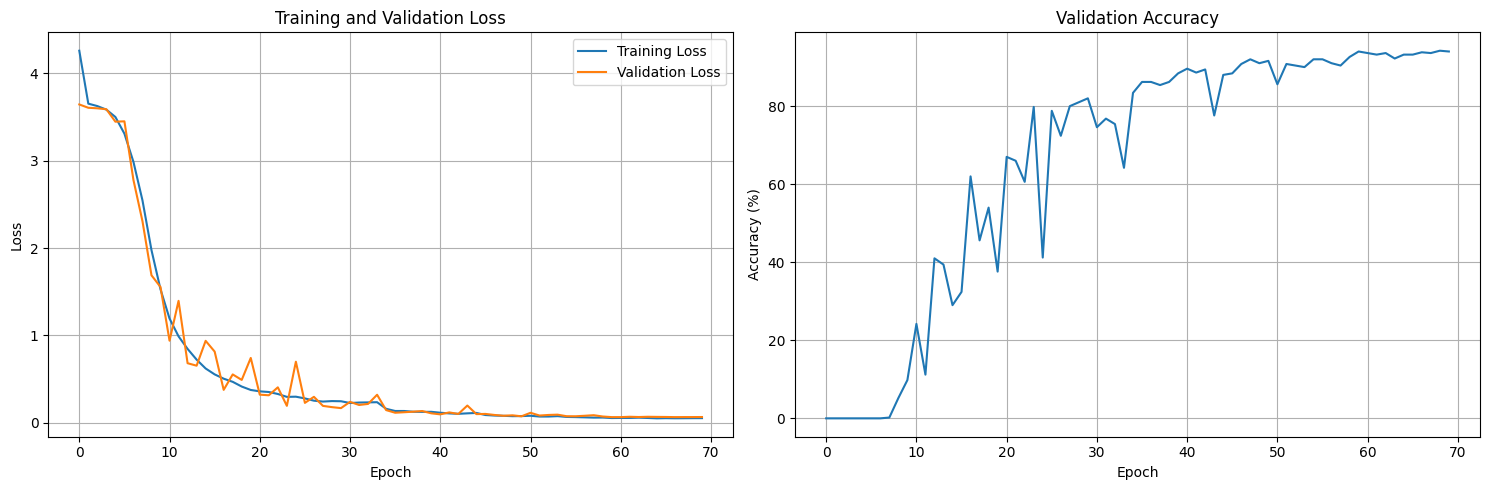

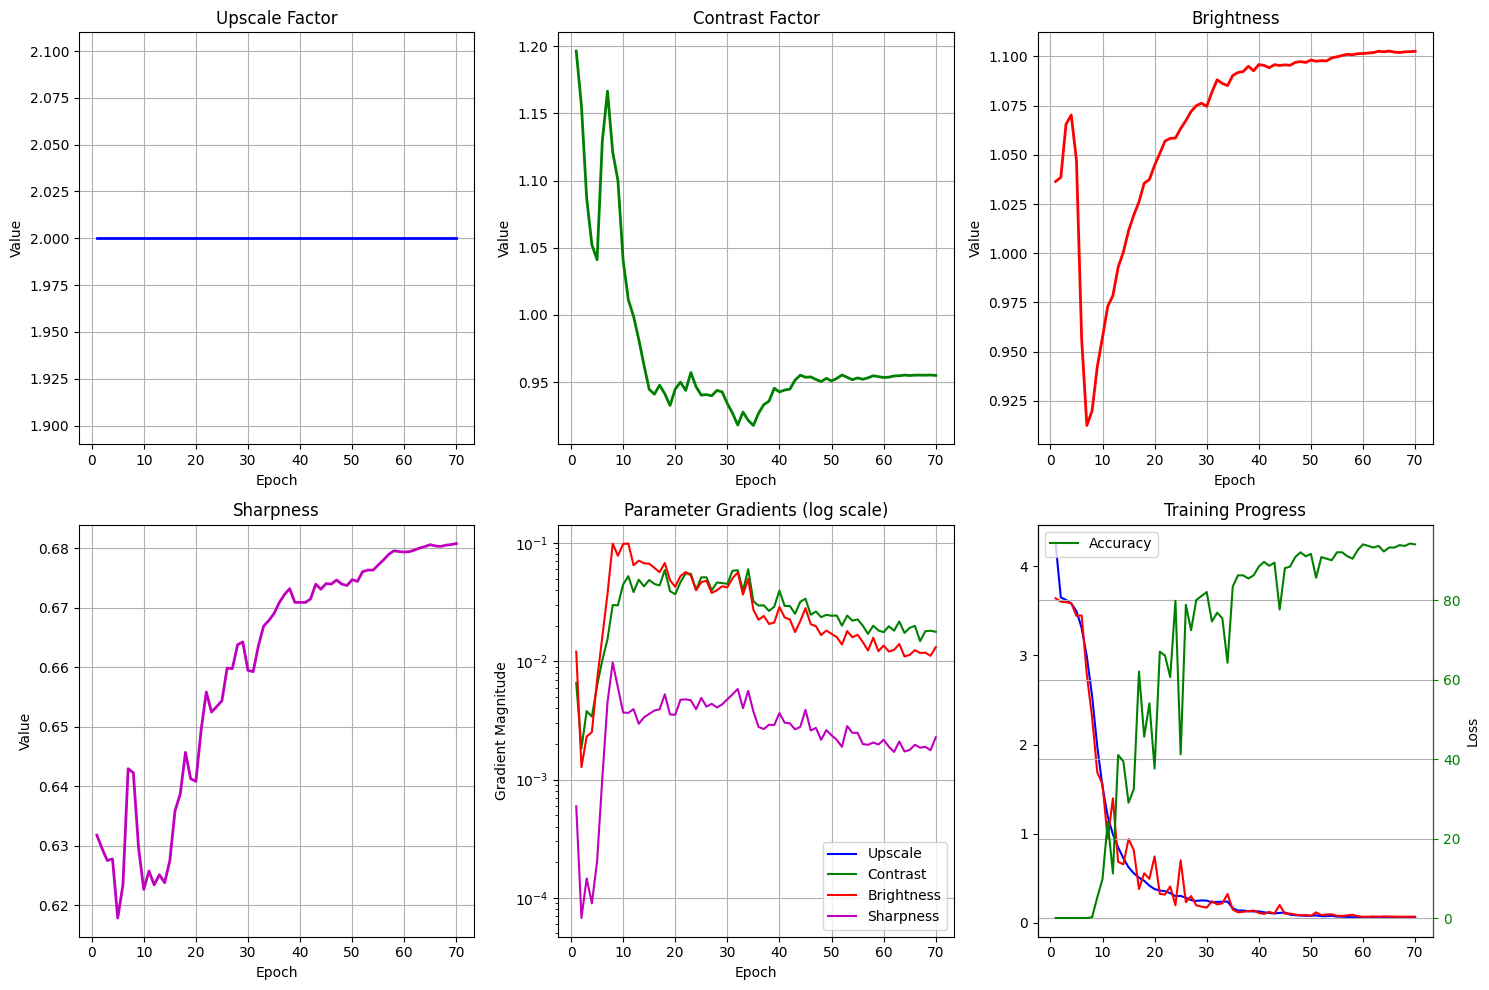


Final preprocessing parameters:
upscale_factor: 2.000 → 2.000 (Change: +0.000)
contrast_factor: 1.196 → 0.955 (Change: -0.241)
brightness: 1.036 → 1.103 (Change: +0.066)
sharpness: 0.632 → 0.681 (Change: +0.049)
sharpen_blend: 0.524 → 0.657 (Change: +0.133)

Optimal preprocessing parameters found by the model:
  upscale_factor: 2.0000
  contrast_factor: 0.9549
  brightness: 1.1026
  sharpness: 0.6808
  sharpen_blend: 0.6570


In [ ]:
def train_model(model, train_loader, val_loader, idx_to_char):
    """Train the model and track performance metrics"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=CONFIG.LEARNING_RATE)

    # CTC Loss for sequence labeling
    criterion = nn.CTCLoss(blank=BLANK_TOKEN, zero_infinity=True)

    # History tracking
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in range(CONFIG.NUM_EPOCHS):
        # Training phase
        model.train()
        train_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG.NUM_EPOCHS}"):
            images = batch['image'].to(device)
            labels = batch['label']
            label_lengths = batch['label_length']

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Prepare for CTC loss
            outputs_trans = outputs.transpose(0, 1)
            input_lengths = torch.full((outputs.size(0),), outputs.size(1), dtype=torch.long)

            # Calculate loss
            loss = criterion(outputs_trans, labels, input_lengths, label_lengths)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Average loss for the epoch
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        # Validation phase
        accuracy, val_loss, correct, total = evaluate_with_loss(
            model, val_loader, device, idx_to_char, criterion
        )
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(accuracy)

        # Log metrics
        print(f"Epoch {epoch+1}/{CONFIG.NUM_EPOCHS} - "
                  f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Validation Accuracy: {accuracy:.2f}% ({correct}/{total})")

    # Save final model
    torch.save(model.state_dict(), CONFIG.MODEL_SAVE_PATH)
    print(f"Model saved to {CONFIG.MODEL_SAVE_PATH}")

    return model, history

if __name__ == "__main__":
    model, history = main_with_trainable_preprocessing()